# Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn import metrics
# import cvxopt # <- installation via conda recommended
from collections import defaultdict
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import nltk
import scipy.optimize as sopt
import scipy.stats as sstats
import csv
from scipy.linalg import solve_triangular

# Motivation

Given LOB (Limit Order Book) data and certain points in time our goal is to predict, whether the price will increase or decrease. <br>
We will be using LOB data from London stock market, collected for September 2013. <br>
Main method used is Logistic regression. <br>

# Data description

Every row of our data represents all active ask and bid orders in some point in time. Row can be described as follows:

$date/time$ $'BID'$ $p_{b1}$ $w_{b1}$ $p_{b2}$ $w_{b2}$ ... $p_{bn}$ $w_{bn}$ $'ASK'$ $p_{a1}$ $w_{a1}$ $p_{a2}$ $w_{a2}$ ... $p_{am}$ $w_{am}$,
where $p_b$, $w_b$ are prices and size of bid order and $p_a$, $w_a$ are prices and sizes of ask order. Prices $p_x$ are sorted ascending. <br>

LOB data is often represented as 3-element tuples $(p_x,w_x,t_x)$, where $p_x,w_x,t_x$ represent price, size and time of $xth$ order and $w_x$ is greater than zero for ask order.

In our case it is convenient to represent the data as a list of pairs, where first element of each pair is bid orders list and second one is ask orders lists. <br>

More formally let $$data = D$$ and for given time ${i}$, $${D_i} = ({BID_i}, {ASK_i})$$  $$BID_{ix} = ({p_x}, {w_x})$$ $$ASK_{ix} = ({p_x}, {w_x})$$ for some index $x$. <br>
Moreover bid and ask lists contain $(p_x, w_x)$ pairs, where $w_x > 0$ for all orders.

We consider orders from $8:30$ to $16:30$ to eliminate abnormal trading behaviour that can occur shortly after the opening auction or shortly before closing auction.

# Data loading

In [2]:
def load_data(path, start_time=83000000, stop_time=163000000):
    X = []
    with open(path,newline='') as file:
        csv_reader = csv.reader(file, delimiter='\t')
        for row in csv_reader:
            date, time = map(int, row[0].split(' '))
            if time < start_time or time > stop_time:
                continue
            
            line = 2
            ASK_list, BID_list = [], []
            
            while line < len(row):
                if row[line] == 'ASK':
                    break
                p,w = map(float, row[line: line+2])
                BID_list.append((p, w))
                line += 2
            line += 1
            while line < len(row):
                p,w = map(float, row[line: line+2])
                ASK_list.append((p, w))
                line += 2
            
            X.append((BID_list, ASK_list))

    return X 

In [3]:
path = "C:\Projekt_ED\OrderBookSnapshots.csv"
data = load_data(path)

In [4]:
len(data)

4810

# Data visualization

## Whole data
(One can see that if ask and bid prices intersect the transaction can be made.)

In [5]:
BID, ASK = [], []

for t in data:
    BID_list = t[0]
    ASK_list = t[1]
    
    BID += BID_list
    ASK += ASK_list
    
BID = np.array(BID)
ASK = np.array(ASK)

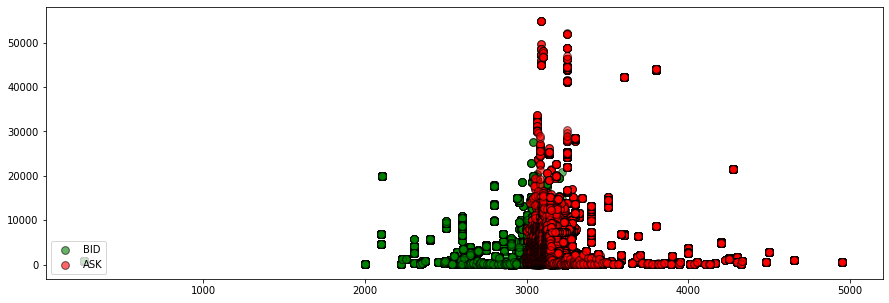

In [6]:
plt.figure(figsize=(15, 5))
plt.scatter(BID[:, 0], BID[:, 1], c='green', alpha=0.6, edgecolors='black', label='BID', s=60)
plt.scatter(ASK[:, 0], ASK[:, 1], c='red', alpha=0.6, edgecolors='black', label='ASK', s=60)
plt.legend(loc='lower left')

## In some fixed time interval
${t}=100$

(0, 6000)

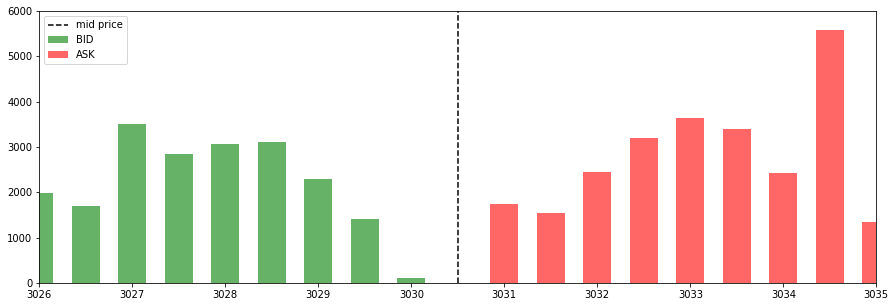

In [7]:
BID, ASK = data[100][0], data[100][1]
BID, ASK = np.array(BID), np.array(ASK)

plt.figure(figsize=(15, 5))
plt.bar(BID[:, 0], BID[:, 1], width=0.3, color='green', alpha=0.6, label='BID')
plt.bar(ASK[:, 0], ASK[:, 1], width=0.3, color='red', alpha=0.6, label='ASK')
plt.vlines(x=3030.5, ymin=0, ymax=10000, label='mid price', linestyles='dashed')
plt.legend(loc='upper left')
plt.xlim(3026, 3035)
plt.ylim(0, 6000)

# Data process functions

At given time $t$, the bid price $b(t)$ is the highest stated price among active buy orders,  
$$b(t) = \max_{x \in BIDlist(t)} p_x $$  
and the ask price $a(t)$ is the lowest stated price among active sell orders,  
$$a(t) = \min_{x \in ASKlist(t)} p_x $$  
The mid price at time $t$ is  
$$m(t) = \frac{a(t)+b(t)}{2} $$  
  
The bid size $n_b(t)$ is total size of active buy orders with price equal to bid price  
$$n_b(t) = \sum_{x \in BIDlist(t) | px = b(t)} w_x $$  
and ask size $n_b(t)$ is total size of active sell orders with price equal to ask price  
$$n_a(t) = \sum_{x \in ASKlist(t) | px = a(t)} w_x $$  
  
At a given time $t$, the queue imbalance $I(t)$ is normalized difference between $n_b(t)$ and $n_a(t)$  
$$I(t) = \frac{n_b(t) - n_a(t)}{n_b(t) + n_a(t)} $$  
  


We can expend those definitions considering k highest (lowest) bid (ask) prices.
<center>$b_k(t) = k-th$ highest price $\in BIDlist(t)$</center>  
   
<center>$a_k(t) = k-th$ lowest price $\in ASKlist(t)$</center>  
  
<center>$n_{k,b}(t) = \sum_{x \in BIDlist(t) | px 	\geqslant b_k(t)} w_x $</center>  
  
<center>$n_{k,a}(t) = \sum_{x \in ASKlist(t) | px \leqslant a_k(t)} w_x $</center>  
  
At a given time $t$, the $k-th$ queue imbalance $I_k(t)$ is normalized difference between $n_{k,b}(t)$ and $n_{k,b}(t)$  
<center>$I_k(t) = \frac{n_{k,b}(t) - n_{k,a}(t)}{n_{k,b}(t) + n_{k,a}(t)} $</center>  


In [8]:
def bid_price(data,t):
    return data[t][0][-1][0]

In [9]:
def ask_price(data,t):
    return data[t][1][0][0]

In [10]:
def mid_price(data,t):
    return (bid_price(data,t) + ask_price(data,t))/2

In [11]:
def bid_size(data,t):
    return data[t][0][-1][1]

In [12]:
def ask_size(data,t):
    return data[t][1][0][1]

In [13]:
def queue_imbalance(data,t):
    nb = bid_size(data,t)
    na = ask_size(data,t)
    return (nb-na)/(nb+na)

In [14]:
def queue_imbalance_k(data,t,k=2):
    sb = 0
    sa = 0
    for i in range(k):
        sb += data[t][0][-(i+1)][1]
        sa += data[t][1][i][1]
    return (sb-sa)/(sb+sa)

## Midprices
If we plot how midprices changed over the time we will get typical auction value graph. <br>
One can see how hard it is to predict, whether the price goes up or down.

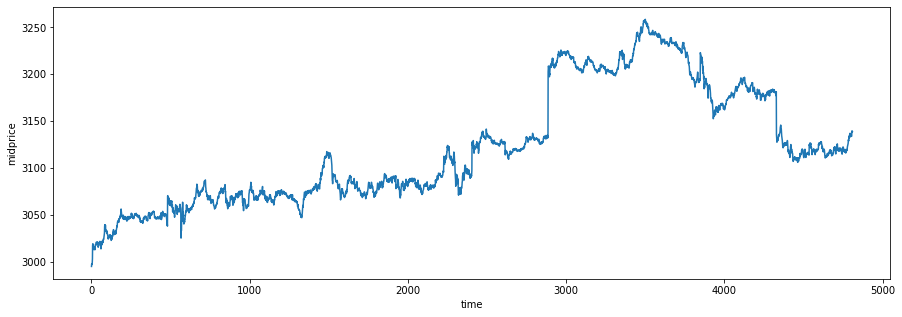

In [15]:
M_x = []
for i in range(len(data)):
    M_x.append(mid_price(data, i))

plt.figure(figsize=(15,5))
plt.plot(range(len(data)), M_x)
plt.ylabel('midprice')
plt.xlabel('time')
plt.show()

# Target defining

First in order to obtain binary targets we consider only moments when the price does change. <br>
Thus let us define vector of those moments:
$$T = [t_x | m(t_x^0) \neq m(t_{x-1}^0)],$$ where $t_x^0$ are all times included in dataset.<br>
Size of this vector equals $N = |T| $. <br>

Now targets are defined as 1 if price increases, 0 otherwise. I.e.
$$
target_x =
\begin{cases}
1 & \text{ if } \ m(t_{x+1}) > m(t_{x}) \\
0 & \text{ if } \ m(t_{x+1}) < m(t_{x})
\end{cases}
$$

Furthermore we shift $T$ forwards by setting ${T_0}$ as 0, <br>
because we want to model ${target_x}$ that happend after moment ${t_x}$.

In [16]:
def get_time_and_target(data):
    T = [0]
    target = []
    for t in range(1, len(data)):
        t_1 = T[-1]
        mt = mid_price(data, t)
        mt_1 = mid_price(data, t_1)
        if mt != mt_1:
            T.append(t)
            if mt > mt_1:
                target.append(1)
            else:
                target.append(0)
    return np.array(T[:-1]), np.array(target)

In [17]:
T, target = get_time_and_target(data)

In [18]:
vals,counts = np.unique(target,return_counts=True)
for i,v in enumerate(vals):
    print(f'Number of data with target = {v}: {counts[i]}')
print(f'Ratio of target = {vals[0]} for train data: {counts[0] / counts.sum()}')

Number of data with target = 0: 2128
Number of data with target = 1: 2208
Ratio of target = 0 for train data: 0.4907749077490775


# Data matrix definition

Now we can define our data matrix.
$$
\begin{bmatrix}
    I_1(t_0) & I_2(t_0) &I_3(t_0) & \dots  & I_K(t_0) \\
    I_1(t_1) & I_2(t_1) &I_3(t_1) & \dots  & I_K(t_1) \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    I_1(t_N) & I_2(t_N) &I_3(t_N) & \dots  & I_K(t_N) \\
\end{bmatrix}
$$
We can notice, that for $K=1$ our data matrix is equal to:
$$
\begin{bmatrix}
    I(t_0) \\
    I(t_1) \\
    \vdots \\
    I(t_N) \\
\end{bmatrix}
$$

In [19]:
K = 2
X = np.array([[queue_imbalance_k(data,t,k) for k in range(1, K+1)] for t in T])
X.dtype

dtype('float64')

## Train test split
We split the data using 80% as train and 20% as test.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
X, target, test_size=0.2, random_state=42, shuffle=False)

## Baseline

We define baseline accuracy for LOB data, so later we can compare it with our model.

In [21]:
vals_train,counts_train = np.unique(y_train,return_counts=True)
for i,v in enumerate(vals_train):
    print(f'Number of train data with target = {v}: {counts_train[i]}')
    print(f'Baseline for target = {v} for train data: {counts_train[i] / counts_train.sum()}')
print()
vals_test,counts_test = np.unique(y_test,return_counts=True)
for i,v in enumerate(vals_test):
    print(f'Number of test data with target = {v}: {counts_test[i]}')
    print(f'Baseline for target = {v} for train data: {counts_test[i] / counts_test.sum()}')


Number of train data with target = 0: 1708
Baseline for target = 0 for train data: 0.4925028835063437
Number of train data with target = 1: 1760
Baseline for target = 1 for train data: 0.5074971164936563

Number of test data with target = 0: 420
Baseline for target = 0 for train data: 0.4838709677419355
Number of test data with target = 1: 448
Baseline for target = 1 for train data: 0.5161290322580645


In [22]:
def print_score(preds,Y,name):
    print(name)
    acc = np.mean(preds == Y)
    print(f"Acc: {acc}")
    M = metrics.confusion_matrix(preds, Y)
    N = np.sum(M)
    print('\nConfusion matrix:')
    print(M)
    print(f'\nTrue negative, (price goes down): {M[0][0]}')
    print(f'True positive, (price goes up): {M[1][1]}')
    print(f'False negative: {M[0][1]}')
    print(f'False positive: {M[1][0]}')
    return M,N,acc

# Logistic regression

Our goal is to predict if $m_{t+1} > m_t$ using data vector
$$
\begin{bmatrix}
    I_1(t) & I_2(t) &I_3(t) & \dots  & I_K(t) \\
\end{bmatrix}
$$

We use logistic regression.
That way we can calculate probability of the sample $x$ belonging to class 1.
$$p(y=1|x) = \sigma(\theta^Tx) = \frac{1}{1 + e^{-\theta^Tx}}$$  

We can observe that:  
$$ p(y=y^{(i)}|x^{(i)};\Theta) = \sigma(\Theta^Tx)^{y^{(i)}}(1-\sigma(\Theta^Tx))^{(1-y^{(i)})}$$  

Therefore the negative log likelihood ($nll$) is:$$
\begin{split}
nll(\Theta) &= -\sum_{i=1}^{N} y^{(i)} \log \sigma(\Theta^Tx) + (1-y^{(i)})\log(1-\sigma(\Theta^Tx)) = \\
&= -\sum_{i=1}^{N}y^{(i)}\log p(y=1|x^{(i)}; \Theta) + (1-y^{(i)})\log  p(y=0|x^{(i)}; \Theta)
\end{split}
$$

So we are searching for $\theta$:
$$\theta = arg\,min_{\theta} \ nll(\theta) $$  
  
We can further consider logistic regression with regularization, where:$$
\begin{split}
nll(\Theta) &= -\sum_{i=1}^{N}y^{(i)}\log p(y=1|x^{(i)}; \Theta) + (1-y^{(i)})\log  p(y=0|x^{(i)}; \Theta) + \frac{\lambda}{2} \sum_{i}\theta_{i}^{2}
\end{split}
$$

There are a few ways to find $\theta$. First we will consider Newtod-Raphson Method and L-BFGS-B solver, then we will compare results with sklearn LogisticRegression.

Newton's method is an iterative method for finding the roots of a differentiable function $F$, which are solutions to the equation $F(x) = 0$. For give start approximation $x_n$ we can calculate better approximation of the root:  
$$x_{n+1} = x_n - \frac{f(x)}{f'(x)} $$  
  
We can use this method to find root of $F'$, where is local optimum of $F$.  
  
For given approximation $x_n$ we can calculate better approximation of local optimum:  
$$x_{n+1} = x_n - \gamma [f''(x_n)]^{-1} f'(x_n) $$
$$\text{where} \ 0<\gamma<1,$$
$$f'(x) = \nabla f(x) \in \mathbb {R} ^{d}$$
$$ f''(x)=\nabla ^{2}f(x)=H_{f}(x) \in \mathbb {R} ^{d\times d} $$
$$H_{f}(x) \  \text{is Hessian matrix and} \ \gamma \ \text{is step size.}$$

## L-BFGS-B solver

L-BFGS-B solver tries to find optimum of $f$ function using $\nabla f(x)$.

In [23]:
class Logistic_Regression:
    def __init__(self, max_iter=500, solver_calls=5, lambda_=0.5, Theta=None, \
                 solver='l_bfgs_b', debug=False):
        self.Theta = Theta
        self.solver_calls = solver_calls
        self.max_iter = max_iter
        self.solver = solver
        self.debug = debug
        self.lambda_ = lambda_
    
    def __sigmoid(self,x):
        return 1 / (1 + np.exp(-x))   
    
    def __gradient(self,x,y,Theta):
        SZ = self.__sigmoid(np.dot(Theta,x.T))
        return np.dot(x.T, (y-SZ).T) + self.lambda_ * Theta
    
    def __hessian(self,x,y,Theta):
        SZ = self.__sigmoid(np.dot(Theta,x.T))
        hess = np.dot(x.T,x * (SZ).reshape(-1,1) * (1 - SZ).reshape(-1,1))
        hess += np.eye(hess.shape[0]) * self.lambda_
        return hess
    
    def __logreg_loss(self, Theta, X, Y):
        Theta = Theta.astype(np.float64)
        X = X.astype(np.float64)
        Y = Y.astype(np.float64)
        
        if self.debug:
            print(f"Loss calculating... ",end="")
        Z = np.dot(Theta,X.T)
        if self.debug:
            print(f" Z done... ",end="")
        SZ = self.__sigmoid(Z)
        Y_ = Y[:,np.newaxis]
        nll = -np.sum((Y_*np.log2(SZ+1e-50) + (1-Y_)*np.log2(1-SZ+1e-50)))
        nll += (self.lambda_/2) * np.sum(Theta**2)
        if self.debug:
            print(f" nll done... ",end="")
        grad = np.dot(X.T, (SZ - Y).T)
        grad = grad.reshape(Theta.shape) + self.lambda_ * Theta
        if self.debug:
            print(f" grad done... done ")
        return nll, grad
    
    
    def fit(self,X,y):
        if self.solver == 'l_bfgs_b':
            Theta = self.Theta
            if Theta is None:
                Theta = np.ones(X.shape[1]+1)

            X_with_ones = np.hstack((np.ones((X.shape[0],1)),X))

            for i in tqdm(range(self.solver_calls), desc='Calculating Theta', position=0):
                Theta = sopt.fmin_l_bfgs_b(lambda th: self.__logreg_loss(th, X_with_ones, y), 
                                    Theta, maxiter=self.max_iter)[0]
            self.Theta = Theta
            
        elif self.solver == 'newton':
            X_with_ones = np.hstack((np.ones((X.shape[0],1)),X))
            Theta = np.ones(X.shape[1]+1)
            g = self.__gradient(X_with_ones,y,Theta)
            i = 0
            while not np.all(np.isclose(g, 0, atol=0.00001)) and i < self.max_iter:
                hess_inv = np.linalg.inv(self.__hessian(X_with_ones, y, Theta))
                Theta = np.add(Theta, np.dot(hess_inv, g))
                g = self.__gradient(X_with_ones, y, Theta)
                i += 1
            self.Theta = Theta
        
        else:
            print(f'Wrong solver!: {self.solver}')
            

    def predict(self, X, threshold=0.5):
        X_with_ones = np.hstack((np.ones((X.shape[0],1)),X))
        preds = self.__sigmoid(np.dot(self.Theta, X_with_ones.T)) >= threshold
#         preds = np.dot(self.Theta, X_with_ones.T) >= 0
        return preds

In [24]:
LR_solver = Logistic_Regression(solver='l_bfgs_b')

In [25]:
LR_solver.fit(X_train,y_train)
preds_train_solver = LR_solver.predict(X_train)

Calculating Theta: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.25s/it]


In [26]:
M,N,acc = print_score(preds_train_solver,y_train,
                      'Train data, L-BFGS-B solver, lambda=0.5')

Train data, L-BFGS-B solver, lambda=0.5
Acc: 0.5406574394463668

Confusion matrix:
[[ 820  705]
 [ 888 1055]]

True negative, (price goes down): 820
True positive, (price goes up): 1055
False negative: 705
False positive: 888


In [27]:
preds_test_solver = LR_solver.predict(X_test)

In [28]:
M,N,acc = print_score(preds_test_solver,y_test,
                      'Test data, L-BFGS-B solver, lambda=0.5')

Test data, L-BFGS-B solver, lambda=0.5
Acc: 0.543778801843318

Confusion matrix:
[[168 144]
 [252 304]]

True negative, (price goes down): 168
True positive, (price goes up): 304
False negative: 144
False positive: 252


## Newtod-Raphson Method

In [29]:
LR_newton = Logistic_Regression(solver='newton')

In [30]:
LR_newton.fit(X_train, y_train)

In [31]:
preds_train_newton = LR_newton.predict(X_train, threshold=0.5)

In [32]:
M,N,acc = print_score(preds_train_newton,y_train,
                      'Train data, Newton method, lambda=0.5')

Train data, Newton method, lambda=0.5
Acc: 0.540080738177624

Confusion matrix:
[[ 845  732]
 [ 863 1028]]

True negative, (price goes down): 845
True positive, (price goes up): 1028
False negative: 732
False positive: 863


In [33]:
preds_test_newton = LR_newton.predict(X_test)

In [34]:
M,N,acc = print_score(preds_test_newton,y_test,
                      'Test data, Newton method, lambda=0.5')

Test data, Newton method, lambda=0.5
Acc: 0.5552995391705069

Confusion matrix:
[[189 155]
 [231 293]]

True negative, (price goes down): 189
True positive, (price goes up): 293
False negative: 155
False positive: 231


## Sklearn

We also consider Sklearn implementation of Logistic Regression with L-BFGS-B solver.

In [35]:
LR_sklearn = LogisticRegression(solver='lbfgs')

In [36]:
LR_sklearn.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [37]:
preds_train_sklearn = LR_sklearn.predict(X_train)

In [38]:
print_score(preds_train_sklearn,y_train,
                      'Train data, sklearn LR, C=1.0')

Train data, sklearn LR, C=1.0
Acc: 0.5403690888119954

Confusion matrix:
[[ 846  732]
 [ 862 1028]]

True negative, (price goes down): 846
True positive, (price goes up): 1028
False negative: 732
False positive: 862


(array([[ 846,  732],
        [ 862, 1028]], dtype=int64), 3468, 0.5403690888119954)

In [39]:
preds_test_sklearn = LR_sklearn.predict(X_test)

In [40]:
print_score(preds_test_sklearn,y_test,
                      'Test data, sklearn LR, C=1.0')

Test data, sklearn LR, C=1.0
Acc: 0.5576036866359447

Confusion matrix:
[[190 154]
 [230 294]]

True negative, (price goes down): 190
True positive, (price goes up): 294
False negative: 154
False positive: 230


(array([[190, 154],
        [230, 294]], dtype=int64), 868, 0.5576036866359447)

## Testing our regression for different Ks

In [41]:
def plot_bar(X, Y1, Y2, title, x_title, width=0.02, a=0, b=-1):
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{:.2f}%'.format(height * 100),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
        
    fig, ax = plt.subplots(figsize=(15,5))
    rects1 = ax.bar(X[a: b] - width/2, Y1[a: b], width, label='Train')
    rects2 = ax.bar(X[a: b] + width/2, Y2[a: b], width, label='Test')
    ax.set_ylabel('Accuracy')
    ax.set_xlabel(x_title)
    ax.set_xticks(X[a: b])
    ax.set_ylim([0, 0.7])
    ax.set_title(title)
    ax.legend(loc='lower right')
    autolabel(rects1)
    autolabel(rects2)
    
    
def plot(X, Y1, Y2, title, x_title):
    plt.plot(X, Y1, label='Train')
    plt.plot(X, Y2, label='Test')
    plt.title(title)
    plt.legend(loc='lower left')
    plt.xlabel(x_title)
    plt.ylabel('Accuracy')

In [42]:
train_c, test_c = [], []
k_list = np.arange(1, 11)

for K in k_list:
    X = np.array([[queue_imbalance_k(data,t,k) for k in range(1,K+1)] for t in T])
    X_train, X_test, y_train, y_test = train_test_split(
        X, target, test_size=0.2, random_state=42,shuffle=False)
    LR = Logistic_Regression(solver='newton')
    LR.fit(X_train, y_train)
    preds_train = LR.predict(X_train)
    train_c.append(np.mean(preds_train == y_train))
    preds_test = LR.predict(X_test)
    test_c.append(np.mean(preds_test == y_test))

train_c = np.array(train_c)
test_c = np.array(test_c)

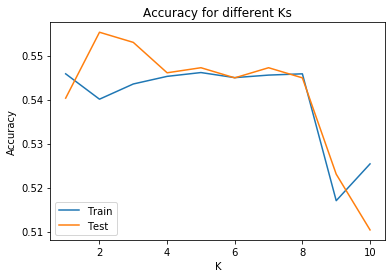

In [43]:
plot(X=k_list, Y1=train_c, Y2=test_c, title='Accuracy for different Ks', \
     x_title='K')

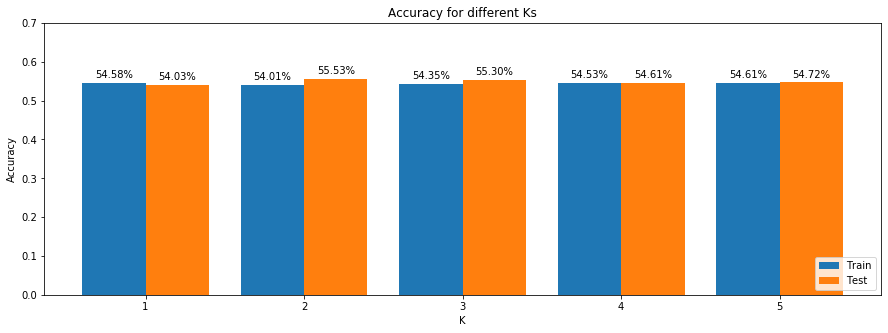

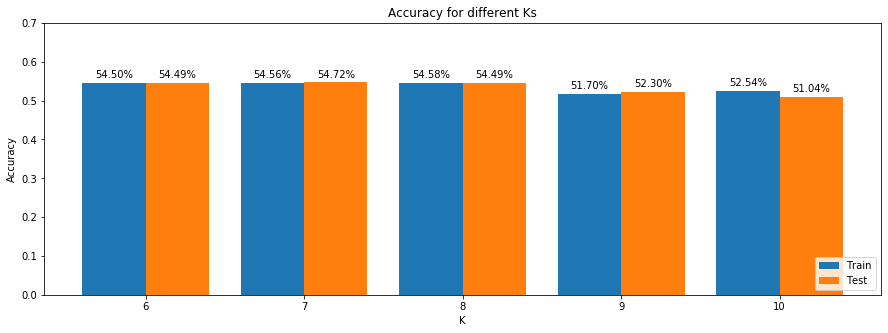

In [44]:
plot_bar(X=k_list, Y1=train_c, Y2=test_c, title='Accuracy for different Ks', \
         x_title='K', width=0.4, b=len(k_list) // 2)
plot_bar(X=k_list, Y1=train_c, Y2=test_c, title='Accuracy for different Ks', \
         x_title='K', width=0.4, a=len(k_list) // 2, b=len(k_list))

In [45]:
# chosing best K
best_k = k_list[np.argmax(test_c)]
print(f'Best K: {best_k}')

Best K: 2


## Testing for different Cs

In [46]:
train_c, test_c = [], []
C_list = np.r_[np.linspace(0.01,1,9), np.linspace(1,10,9)]

X = np.array([[queue_imbalance_k(data,t,k) for k in range(1, best_k+1)] for t in T])
X_train, X_test, y_train, y_test = train_test_split(
    X, target, test_size=0.2, random_state=42,shuffle=False)
    
for C in C_list:
    LR = Logistic_Regression(solver='newton', lambda_=C)
    LR.fit(X_train, y_train)
    preds_train = LR.predict(X_train)
    train_c.append(np.mean(preds_train == y_train))
    preds_test = LR.predict(X_test)
    test_c.append(np.mean(preds_test == y_test))

train_c = np.array(train_c)
test_c = np.array(test_c)

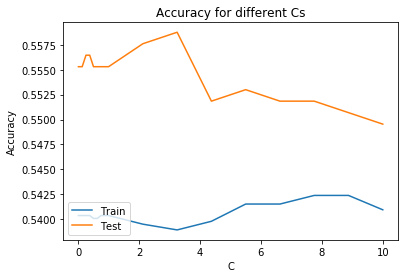

In [47]:
plot(X=C_list, Y1=train_c, Y2=test_c, title='Accuracy for different Cs',\
     x_title='C')

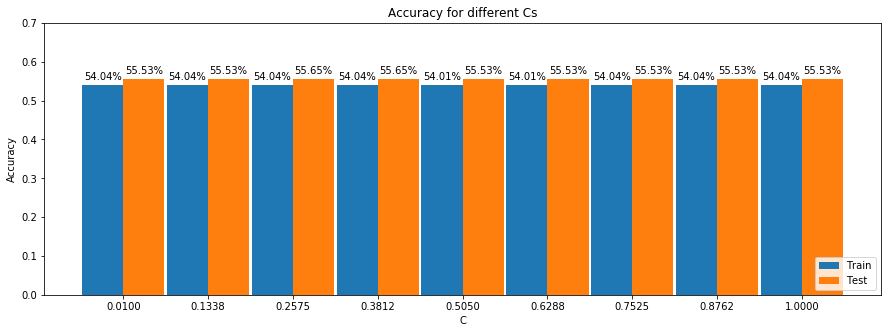

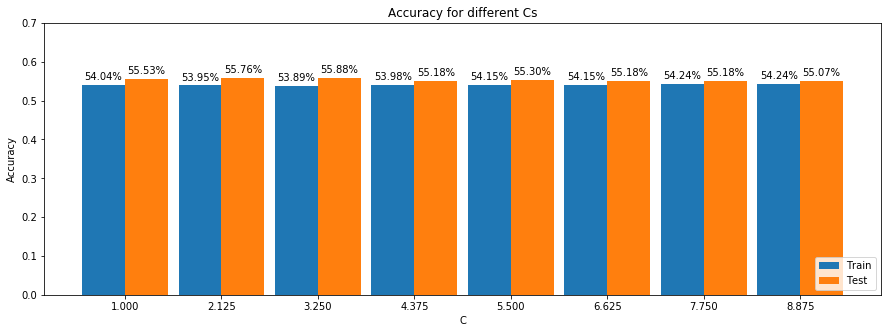

In [48]:
plot_bar(X=C_list, Y1=train_c, Y2=test_c, title='Accuracy for different Cs', \
         x_title='C', width=0.06, b=len(C_list) // 2)
plot_bar(X=C_list, Y1=train_c, Y2=test_c, title='Accuracy for different Cs', \
         x_title='C', width=0.5, a=len(C_list) // 2, b=-1)

In [49]:
# chose best C
best_c = C_list[np.argmax(test_c)]
print(f'Best c: {best_c}')

Best c: 3.25


## Testing different thresholds

In [50]:
# we will also save FP and TP rate for later

train_c, test_c = [], []
FPR, TPR, TNR = [], [], []
threshold = np.linspace(0, 1, 25)
X = np.array([[queue_imbalance_k(data,t,k) for k in range(1, best_k+1)] for t in T])
X_train, X_test, y_train, y_test = train_test_split(
    X, target, test_size=0.2, random_state=42,shuffle=False)
    
for th in threshold:
    LR = Logistic_Regression(solver='newton', lambda_=best_c)
    LR.fit(X_train, y_train)
    preds_train = LR.predict(X_train, threshold=th)
    train_c.append(np.mean(preds_train == y_train))
    preds_test = LR.predict(X_test, threshold=th)
    test_c.append(np.mean(preds_test == y_test))
    M = metrics.confusion_matrix(preds_test, y_test)
    TP, FP = M[1][1], M[1][0]
    TN, FN = M[0][0], M[0][1]
    FPR.append(FP / (FP + TN + 1e-50))
    TPR.append(TP / (TP + FN + 1e-50))
    TNR.append(TN / (TN + FP + 1e-50))

train_c = np.array(train_c)
test_c = np.array(test_c)

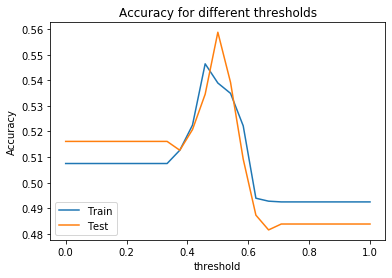

In [51]:
plot(X=threshold, Y1=train_c, Y2=test_c, title='Accuracy for different thresholds', \
     x_title='threshold')

In [52]:
best_accuracy=np.max(test_c)

In [53]:
print(f'Best accuracy: {best_accuracy} for K: {best_k}, lambda: {best_c}, \
treshold: {threshold[np.argmax(test_c)]}')

Best accuracy: 0.5587557603686636 for K: 2, lambda: 3.25, treshold: 0.5


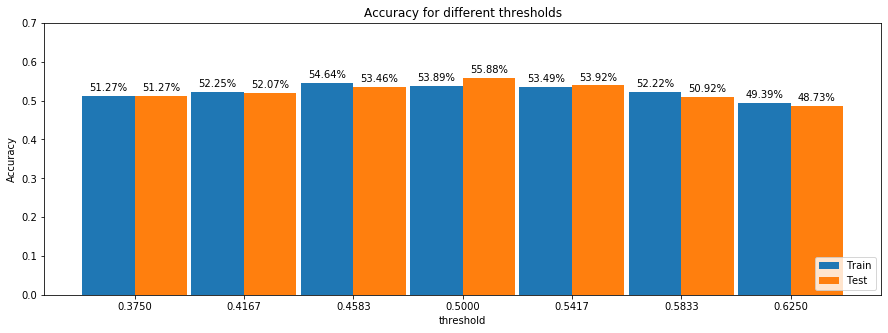

In [54]:
plot_bar(X=threshold, Y1=train_c, Y2=test_c, title='Accuracy for different thresholds', \
         x_title='threshold', width=0.02, a=len(threshold) // 2 - 3, b=len(threshold) // 2 + 4) 

# Receiver operating characteristic

ROC curve, is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied. <br>
The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings. <br>

To assess the predictive power of our logistic regressions for performing binary <br>
and probabilistic classification, we compare their output to that of a simple null <br>
model in which we assume that I provides no useful information for predicting <br> 
the direction of mid-price movements, such that for all $I$: <br>

$$y(I) = \frac{1}{2}$$

In words, our null model predicts that the probability of an upward or downward price movement is always 50%, irrespective of the queue imbalance. <br>
We calculate area under the curve by a number of trapezoidal approximations. I.e. sum of triangles and rectangles. <br>


In [55]:
def area_under_roc(TPR, FPR):
    ans = 0
    for k in range(1, len(TPR)):
        triange = abs(FPR[k] - FPR[k-1]) * (TPR[k] - TPR[k-1]) / 2
        rectangle = abs((FPR[k] - FPR[k-1]) * min(TPR[k], TPR[k-1]))
        ans += triange + rectangle
        
    return ans

# Results

## Sensitivity (true positive rate) and Specificity (true negative rate)
Measures the proportion of actual positives/negatives that are correctly identified as such.

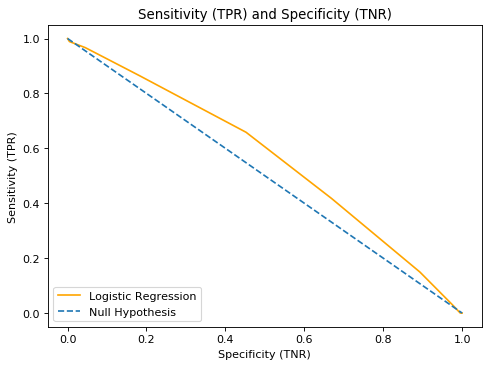

Area under the curve: 0.5631962159863946


In [56]:
plt.figure(num=None, figsize=(7, 5), dpi=80, facecolor='w', edgecolor='k')
plt.plot(TNR, TPR, c='orange', label="Logistic Regression")
plt.plot([0,1],[1,0], linestyle='--', label="Null Hypothesis")
plt.xlabel('Specificity (TNR)')
plt.ylabel('Sensitivity (TPR)')
plt.title('Sensitivity (TPR) and Specificity (TNR)')
plt.legend(loc='lower left')
plt.show()

print(f'Area under the curve: {area_under_roc(TNR, TPR)}')

## ROC curve: False alarm (FPR) and Sensitivity (TPR) 

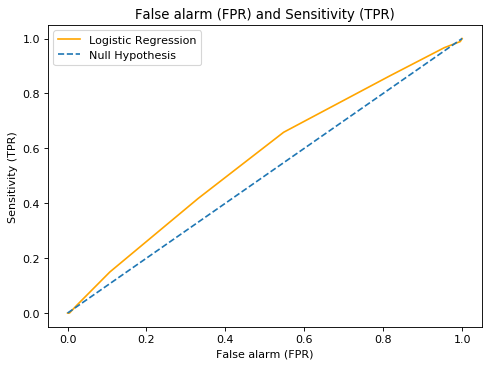

Area under the curve: 0.5631962159863946


In [57]:
plt.figure(num=None, figsize=(7, 5), dpi=80, facecolor='w', edgecolor='k')
plt.plot(FPR, TPR, c='orange', label="Logistic Regression")
plt.plot([0,1],[0,1], linestyle='--', label="Null Hypothesis")
plt.xlabel('False alarm (FPR)')
plt.ylabel('Sensitivity (TPR)')
plt.title('False alarm (FPR) and Sensitivity (TPR)')
plt.legend(loc='upper left')
plt.show()

print(f'Area under the curve: {area_under_roc(TNR, TPR)}')

## Summary

Baseline accuracy was around 51.6% for test data. <br>
After tuning our Logistic Regression parameters we got results similar to sklearn implementation.
Our model scores 55.88% on test, which is considerably better having in mind that predicting stock market is quite hard task.